<a href="https://colab.research.google.com/github/Ebasurtos/MISTI/blob/main/BASURTO_SIUCE_Eder_Kobe_ensemble_validation_EXERCISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**If you haven't already, please hit :**

`File` -> `Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**


# Model Training with the Kobe Bryant Dataset

In [6]:
# @title
# ==============================================
# 0. Module imports
# ==============================================

# Remove any existing folder
# !rm -rf gsl-uruguay

# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.datasets import make_classification  # To create synthetic classification datasets

# plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Import additional libraries for polynomial regression tasks
from sklearn.preprocessing import PolynomialFeatures  # To generate polynomial features
from sklearn.linear_model import LinearRegression  # To perform linear regression
from sklearn.metrics import mean_squared_error  # For calculating model performance (MSE)

# dimension reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed
import multiprocessing

# text mining
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_auc_score  # Metric to evaluate model's classification performance
from sklearn.metrics import confusion_matrix  # Evaluates predictions by comparing with actual labels
from sklearn.metrics import roc_curve, auc  # Plots and evaluates the ROC curve

import warnings
warnings.filterwarnings("ignore")

### **Download the Data and Upload to Google Colab [5 minutes]**

Download the following data:

https://drive.google.com/file/d/1hQEvGLiZeIYk36JXTZKo5Ghs-vkHkRRm/view?usp=sharing

Upload it to the files in your Google Colab.

*Make sure the file has the name ‘KobeData.csv’, and it is in the same folder as where the sample-data folder is located.*

### Load and preprocess the Data

In this section, we will load the Kobe Bryant dataset into a Pandas DataFrame and perform initial data cleaning to prepare it for analysis. We will filter the dataset to focus on 15 key features relevant to shot performance and remove records with missing values in the target variable (`shot_made_flag`). The resulting dataset will give us a cleaner and more manageable starting point for building predictive models.

In [7]:
# Load the dataset into a pandas DataFrame
KobeDataset_orig = pd.read_csv('KobeData.csv')
print("Data dimensions: " + str(KobeDataset_orig.shape))

# Filter the DataFrame to include only the specified 15 features
KobeDataset_orig = KobeDataset_orig.filter(["action_type", "loc_x", "loc_y", "shot_distance", "shot_zone_basic",
                                  "shot_zone_area", "shot_type", "period", "minutes_remaining",
                                  "seconds_remaining", "playoffs", "season", "game_date", "matchup", "shot_made_flag"])
print("Filtered data dimensions: " + str(KobeDataset_orig.shape))

# Remove records with missing values in the 'shot_made_flag' column
FullLength = len(KobeDataset_orig)
KobeDataset_orig = KobeDataset_orig.loc[~pd.isnull(KobeDataset_orig['shot_made_flag'])]
print("Removed", FullLength - len(KobeDataset_orig), "records with missing 'shot_made_flag' values")

print("Filtered Data dimensions:" + str(KobeDataset_orig.shape))

# Display the first 10 rows of the cleaned dataset
display(KobeDataset_orig.head(10))

Data dimensions: (30697, 31)
Filtered data dimensions: (30697, 15)
Removed 5000 records with missing 'shot_made_flag' values
Filtered Data dimensions:(25697, 15)


,action_type,loc_x,loc_y,shot_distance,shot_zone_basic,shot_zone_area,shot_type,period,minutes_remaining,seconds_remaining,playoffs,season,game_date,matchup,shot_made_flag
1,Jump Shot,-157,0,15.0,Mid-Range,Left Side(L),2PT Field Goal,1,10,22,0,2000-01,10/31/00,LAL @ POR,0.0
2,Jump Shot,-101,135,16.0,Mid-Range,Left Side Center(LC),2PT Field Goal,1,7,45,0,2000-01,10/31/00,LAL @ POR,1.0
3,Jump Shot,138,175,22.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,6,52,0,2000-01,10/31/00,LAL @ POR,0.0
4,Driving Dunk Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,2,6,19,0,2000-01,10/31/00,LAL @ POR,1.0
5,Jump Shot,-145,-11,14.0,Mid-Range,Left Side(L),2PT Field Goal,3,9,32,0,2000-01,10/31/00,LAL @ POR,0.0
6,Layup Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,3,8,52,0,2000-01,10/31/00,LAL @ POR,1.0
8,Jump Shot,-65,108,12.0,In The Paint (Non-RA),Left Side(L),2PT Field Goal,3,6,12,0,2000-01,10/31/00,LAL @ POR,1.0
9,Running Jump Shot,-33,125,12.0,In The Paint (Non-RA),Center(C),2PT Field Goal,3,3,36,0,2000-01,10/31/00,LAL @ POR,0.0
10,Jump Shot,-94,238,25.0,Above the Break 3,Left Side Center(LC),3PT Field Goal,3,1,56,0,2000-01,10/31/00,LAL @ POR,0.0
11,Jump Shot,121,127,17.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,11,0,0,2000-01,11/1/00,LAL vs. UTA,1.0


#### Add in One-Hot Features

To improve the performance of our model, we start by generating **one-hot encoded columns** for each category in the `shot_zone_basic` feature. One-hot encoding transforms categorical variables into a format that machine learning algorithms can process, creating a separate binary column for each unique category. The new columns are named with the prefix **`shot_zone`**, corresponding to different shot zones on the court.

After generating these new features, we add them to the **KobeDataset** to enrich the dataset with location-based shooting information. Finally, we select a set of features that are likely to impact shot success, including **game time factors**, **shot distance**, **court locations**, and the newly created **shot zone features**. These selected features will be used as input for the **logistic regression model** to predict whether a shot was made (`shot_made_flag`).

In [8]:
# Generate one-hot encoded columns for each category in 'shot_zone_basic'
# and use 'shot_zone' as the prefix for the new columns
shot_zones = pd.get_dummies(KobeDataset_orig["shot_zone_basic"], prefix="shot_zone")

# Add this New Feature to your Dataset
KobeDataset = KobeDataset_orig.join(shot_zones)

# Selecting the total set of features
feat = ["minutes_remaining", "seconds_remaining", "shot_distance", "loc_x", "loc_y", 'shot_zone_Above the Break 3', 'shot_zone_Backcourt', 'shot_zone_In The Paint (Non-RA)',
        'shot_zone_Left Corner 3','shot_zone_Mid-Range', 'shot_zone_Restricted Area', 'shot_zone_Right Corner 3']
label = ["shot_made_flag"]

KobeDataset.head()

,action_type,loc_x,loc_y,shot_distance,shot_zone_basic,shot_zone_area,shot_type,period,minutes_remaining,seconds_remaining,...,game_date,matchup,shot_made_flag,shot_zone_Above the Break 3,shot_zone_Backcourt,shot_zone_In The Paint (Non-RA),shot_zone_Left Corner 3,shot_zone_Mid-Range,shot_zone_Restricted Area,shot_zone_Right Corner 3
1,Jump Shot,-157,0,15.0,Mid-Range,Left Side(L),2PT Field Goal,1,10,22,...,10/31/00,LAL @ POR,0.0,False,False,False,False,True,False,False
2,Jump Shot,-101,135,16.0,Mid-Range,Left Side Center(LC),2PT Field Goal,1,7,45,...,10/31/00,LAL @ POR,1.0,False,False,False,False,True,False,False
3,Jump Shot,138,175,22.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,6,52,...,10/31/00,LAL @ POR,0.0,False,False,False,False,True,False,False
4,Driving Dunk Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,2,6,19,...,10/31/00,LAL @ POR,1.0,False,False,False,False,False,True,False
5,Jump Shot,-145,-11,14.0,Mid-Range,Left Side(L),2PT Field Goal,3,9,32,...,10/31/00,LAL @ POR,0.0,False,False,False,False,True,False,False


#### Split the Data

In [9]:
train, val = train_test_split(KobeDataset, test_size= 0.5, train_size= 0.5, random_state= 234)
val, test = train_test_split(val, test_size= 0.5, train_size= 0.5, random_state= 675)

#### EXERCISE: Fix Missing Values of Features and Encode Categorical Data

In this exercise, we'll focus on handling missing values in our dataset. We'll use simple imputation techniques to fill in missing values and then retrain our models with the complete dataset to see how this affects their performance.

Replace the missing data points in the numerical features with their mean.
  - Identify numerical features with missing values by using `DataFrame.info()`.
  - Replace missing values in the feature(s) using the mean of each feature with the `.fillna()` method.
  - Apply this process to the training, validation, and test datasets.
  - Verify that there are no remaining missing values by checking the datasets again with `DataFrame.info()`.

In [12]:
# EXERCISE

KobeDataset.info()

train["shot_distance"] = <REPLACE ME AND MY ARROWS>
val["shot_distance"] = <REPLACE ME AND MY ARROWS>
test["shot_distance"] = <REPLACE ME AND MY ARROWS>

SyntaxError: invalid syntax (ipython-input-2619104954.py, line 5)

In [17]:
# EXERCISE

KobeDataset.info()

train["shot_distance"] = train["shot_distance"].fillna(train["shot_distance"].mean())
val["shot_distance"] = val["shot_distance"].fillna(val["shot_distance"].mean())
test["shot_distance"] = test["shot_distance"].fillna(test["shot_distance"].mean())

<class 'pandas.core.frame.DataFrame'>
Index: 25697 entries, 1 to 30696
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   action_type                      25697 non-null  object 
 1   loc_x                            25697 non-null  int64  
 2   loc_y                            25697 non-null  int64  
 3   shot_distance                    25696 non-null  float64
 4   shot_zone_basic                  25697 non-null  object 
 5   shot_zone_area                   25697 non-null  object 
 6   shot_type                        25697 non-null  object 
 7   period                           25697 non-null  int64  
 8   minutes_remaining                25697 non-null  int64  
 9   seconds_remaining                25697 non-null  int64  
 10  playoffs                         25697 non-null  int64  
 11  season                           25697 non-null  object 
 12  game_date              

In [14]:
# EXERCISE

# KobeDataset.info() # This info is for the original dataset before splitting and filling

train["shot_distance"] = train["shot_distance"].fillna(train["shot_distance"].mean())
val["shot_distance"] = val["shot_distance"].fillna(val["shot_distance"].mean())
test["shot_distance"] = test["shot_distance"].fillna(test["shot_distance"].mean())

print("\nTrain Dataset Info after filling missing values:")
train.info()
print("\nValidation Dataset Info after filling missing values:")
val.info()
print("\nTest Dataset Info after filling missing values:")
test.info()


Train Dataset Info after filling missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 12848 entries, 3856 to 10164
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   action_type                      12848 non-null  object 
 1   loc_x                            12848 non-null  int64  
 2   loc_y                            12848 non-null  int64  
 3   shot_distance                    12848 non-null  float64
 4   shot_zone_basic                  12848 non-null  object 
 5   shot_zone_area                   12848 non-null  object 
 6   shot_type                        12848 non-null  object 
 7   period                           12848 non-null  int64  
 8   minutes_remaining                12848 non-null  int64  
 9   seconds_remaining                12848 non-null  int64  
 10  playoffs                         12848 non-null  int64  
 11  season                          

### EXERCISE: Fit Logistic Regression Model & evaluate performance

In this exercise, we'll start by creating baseline models using simple numerical features without any missing values. This will give us a foundation to build upon as we add more complexity to our models.

  - Use all features
  - Define the target variable as `shot_made_flag`.
  - Use the LogisticRegression() class from sklearn.linear_model to create a logistic regression model.
  - Fit the model using the training dataset.
  - Predict probabilities on the validation dataset using `predict_proba()`.

#### TASK 1: Train a Logistic Regression Model

In [18]:
# TASK 1 EXERCISE

# Train a `LogisticRegression()` model
logReg = LogisticRegression()
logReg.fit(train[feat], train[label])

# predict class probabilities on validation data
logReg_val = logReg.predict_proba(val[feat])[:, 1]

#### TASK 2: Confusion Matrix with Logistic Regression
In this exercise, we'll use a confusion matrix to analyze the performance of the logistic regression model above, which will show us how accurately it classifies Kobe Bryant's shots as made or missed.

Tasks:
2a. Use the trained model to predict classes for the validation set.
2b. Calculate the confusion matrix for the trained logistic regression using the `confusion_matrix()` function and plot it.
2c. Extract the values from the confusion matrix using `conf_matrix.ravel()`. Use the extracted values to calculate the listed performance metrics. The confusion matrix contains the following values:
  - TP (True Positive)
  - TN (True Negative)
  - FP (False Positive)
  - FN (False Negative)

##### TASK 2a: Generate and Plot the Confusion Matrix

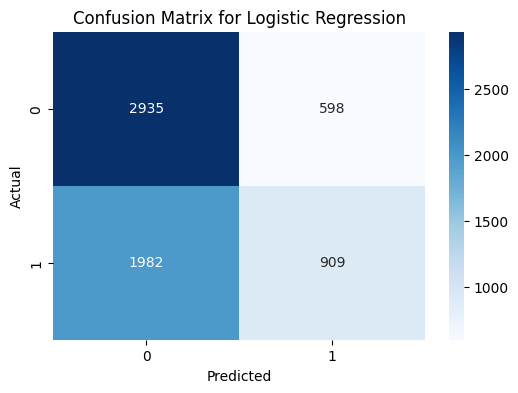

In [19]:
# TASK 2a EXERCISE

# Predict class labels on validation data
logReg_val_class = logReg.predict(val[feat])

# Create confusion matrix
conf_matrix = confusion_matrix(val[label], logReg_val_class)

# Plot confusion matrix using heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##### TASK 2b: Extract the Confusion matrix metrics and then Use them to Calculate Relevant Additional Metrics

In [20]:
# TASK 2b EXERCISE

# Extract values from the confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Recall (Sensitivity or True Positive Rate)
recall_calculation = TP / (TP + FN)

# Precision
precision_calculation = TP / (TP + FP)

# Accuracy
accuracy_calculation = (TP + TN) / (TP + TN + FP + FN)

# Sensitivity (same as Recall or True Positive Rate)
sensitivity_calculation = TP / (TP + FN)

# Specificity (True Negative Rate)
specificity_calculation = TN / (TN + FP)

# False Positive Rate
false_positive_rate_calculation = FP / (FP + TN)

# True Negative Rate (same as Specificity)
true_negative_rate_calculation = TN / (TN + FP)

# True Positive Rate (same as Sensitivity or Recall)
true_positive_rate_calculation = TP / (TP + FN)

# Print all calculated metrics based on the confusion matrix
calculated_metrics = {
    "Recall (Sensitivity or TPR)": recall_calculation,
    "Precision": precision_calculation,
    "Accuracy": accuracy_calculation,
    "Sensitivity": sensitivity_calculation,
    "Specificity (TNR)": specificity_calculation,
    "False Positive Rate (FPR)": false_positive_rate_calculation,
    "True Negative Rate (TNR)": true_negative_rate_calculation,
    "True Positive Rate (TPR)": true_positive_rate_calculation,
}

for metric, value in calculated_metrics.items():
    print(f"{metric}: {value:.4f}")

Recall (Sensitivity or TPR): 0.3144
Precision: 0.6032
Accuracy: 0.5984
Sensitivity: 0.3144
Specificity (TNR): 0.8307
False Positive Rate (FPR): 0.1693
True Negative Rate (TNR): 0.8307
True Positive Rate (TPR): 0.3144


#### Task 2c: Calculate the Receiver Operator Characteristic Curve and Area under the Curve (AUC)

In this exercise, we'll plot and analyze the ROC curve and calculate the AUC metric to evaluate our model's performance across different classification thresholds. This will help us understand how well our model discriminates between made and missed shots at various sensitivity levels.

Use the **[roc_curve](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)** function to compute the ROC curve based on predicted class probabilities of the logistic regression model.


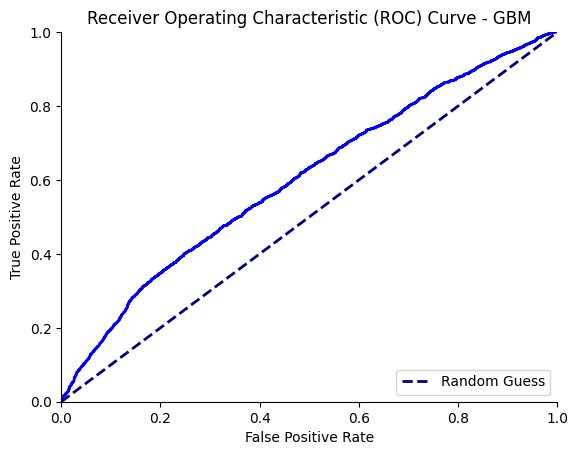

Logistic Performance (AUC): 0.60194


In [21]:
# Task 2c exercise
# Predict class probabilities using your trained logReg model on the validation set
logReg_val_prob = logReg_val

# Calculate false positive and true positive rates true labels using roc_curve function
fprs_function_logReg, tprs_function_logReg, _ = roc_curve(val[label], logReg_val_prob)

# Plot ROC curve
plt.figure()
plt.plot(fprs_function_logReg, tprs_function_logReg, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - GBM')
plt.legend(loc="lower right")
sns.despine()
plt.show()

# Compute the AUC score using the Pandas series of predicted class probabilities
print("Logistic Performance (AUC): " + str(np.round(roc_auc_score(val[label], logReg_val), 5)))

Going forward, we'll be using the **Area Under the ROC Curve (AUC)** to compare performances of all models.

### EXERCISE: Train a `GradientBoostingClassifier()` and assess feature importance

  - Use all features
  - Define the target variable as `shot_made_flag`.
  - Use the `GradientBoostingClassifier()` class from sklearn.ensemble to create a gradient boosting model.
  - Fit the model using the training dataset.
  - Predict probabilities on the validation dataset using `predict_proba()`.
  - Evaluate the model performance by calculating the AUC score with `roc_auc_score()`.

#### TASK 1: Train gradient boosting classifier

In [22]:
# TASK 1 EXERCISE

# Train a `GradientBoostingClassifier()` model
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(train[feat], train[label].values.ravel())

# predict class probabilities on validation data
gbm_val = gbm.predict_proba(val[feat])[:, 1]

# auc score
print("GBM Performance (AUC): " + str(np.round(roc_auc_score(val[label], gbm_val), 5)))

GBM Performance (AUC): 0.59845


#### TASK 2: Which Features are the Most Important?

Identify which features are the most important in our classification. Which are the least important?
  - Use the `feature_importances_` attribute of the fitted `GradientBoostingClassifier()` model to identify feature importance.
  - Create a DataFrame with feature names and their corresponding importance values.

                               feat       imp
0                 minutes_remaining  0.076503
1                 seconds_remaining  0.087378
2                     shot_distance  0.558735
3                             loc_x  0.162392
4                             loc_y  0.101438
5       shot_zone_Above the Break 3  0.000000
6               shot_zone_Backcourt  0.000000
7   shot_zone_In The Paint (Non-RA)  0.011471
8           shot_zone_Left Corner 3  0.000000
9               shot_zone_Mid-Range  0.002054
10        shot_zone_Restricted Area  0.000029
11         shot_zone_Right Corner 3  0.000000


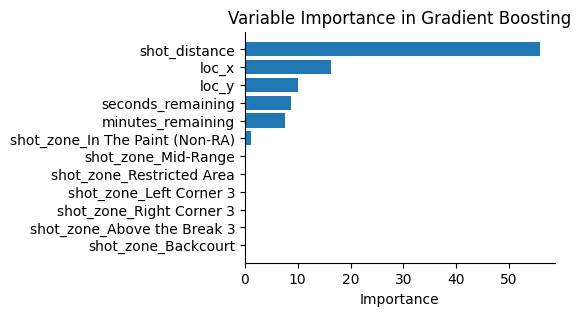

In [23]:
# TASK 2 EXERCISE

gbm_feat_imp = pd.DataFrame({
    "feat": feat,
    "imp": gbm.feature_importances_
})

print(gbm_feat_imp)

# lets visualize this
gbm_feat_imp = gbm_feat_imp.sort_values(by = ["imp"], ascending= True)
pos = np.arange(gbm_feat_imp.shape[0]) + 0.5
plt.figure(figsize=(4, 3))
plt.subplot(1, 1, 1)
plt.barh(pos, gbm_feat_imp.imp.values*100, align='center')
plt.yticks(pos, gbm_feat_imp.feat.values)
plt.xlabel("Importance")
plt.title("Variable Importance in Gradient Boosting")
sns.despine()
plt.show()

##Ensemble Learning

### EXERCISE: Random Forest and Extremely Randomized Trees

Tasks:
1. Train a RandomForestClassifier()
  - Use the RandomForestClassifier() class from sklearn.ensemble to build a Random Forest model.
  - Use the base numerical features.
  - Define the target variable as "shot_made_flag".
  - Fit the model on the training dataset.
  - Make predictions on the validation dataset.
  - Evaluate the model's performance by calculating the AUC score
   and then print the AUC score for comparison.
2. Train a Extremely Randomized Tree `ExtraTreesClassifier()` with the same steps as task 1.

##### TASK 1: Train a Random Forest Classifier

In [24]:
# TASK 1 EXERCISE

# Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(train[feat], train[label].values.ravel())

# predict on validation data
rf_val = rf.predict_proba(val[feat])[:, 1]

# Compute & print AUC score
print("Random Forest Performance (AUC): " + str(np.round(roc_auc_score(val[label], rf_val), 5)))

Random Forest Performance (AUC): 0.55359


##### TASK 2: Train an Extremely Randomized Tree

In [25]:
# TASK 2 EXERCISE

# Train an Extremely Randomized Tree
ert = ExtraTreesClassifier(random_state=42)
ert.fit(train[feat], train[label].values.ravel())

# predict on validation data
ert_val = ert.predict_proba(val[feat])[:, 1]

# Compute & print AUC score
print("Extremely Randomized Trees Performance (AUC): " + str(np.round(roc_auc_score(val[label], ert_val), 5)))

Extremely Randomized Trees Performance (AUC): 0.55301


### EXERCISE: Ensemble Learning

Tasks:
1. Create a Simple Average Ensemble
  - Combine the predictions from three models: `LogisticRegression()`, `ExtraTreesClassifier()`, and `RandomForestClassifier()`.
  - Use `np.mean()` to calculate the average prediction across these models.
  - Evaluate the ensemble’s performance using the AUC score.
  - Print the AUC score to compare with individual model performances.
2. Add the `GradientBoostingClassifier()` to the Simple Average Ensemble
  - Update the simple average ensemble to include predictions from the `GradientBoostingClassifier()`.
  - Calculate the new average prediction across four models: `LogisticRegression()`, `ExtraTreesClassifier()`, `RandomForestClassifier()`, and `GradientBoostingClassifier()`.
  - Evaluate the updated ensemble’s performance using the AUC score.
  - Print the new AUC score for comparison.
3. Create a Weighted Average Ensemble
  - Create a weighted average ensemble by assigning different weights to the models based on their performance.
  - Experiment with different weight values to optimize the performance of the ensemble.
  - Evaluate the performance of the weighted average ensemble using the AUC score.
  - Print the AUC score to see if it improves compared to the simple average ensemble.

#### TASK 1: Create a Simple Average Ensemble

In [26]:
# TASK 1 EXERCISE

# Simple blend of Logistic Regression, Extra Trees, and Random Forest
# Combine predicted validation set probabilities
simple_avg_val = np.mean([logReg_val, ert_val, rf_val], axis=0)

# Evaluate the ensemble
auc_score = roc_auc_score(val[label], simple_avg_val)

print("Simple Avg Ensemble Performance (AUC):", round(auc_score, 5))

Simple Avg Ensemble Performance (AUC): 0.56852


#### TASK 2: Add the GradientBoostingClassifier() to the Ensemble

In [27]:
# TASK 2 EXERCISE

# auc score
print("GBM Base (AUC): " + str(np.round(roc_auc_score(val[label], gbm_val), 5)))

print(" -- -- -- ")

# Simple blend of Logistic Regression, Gradient Boosting, Extra Trees, and Random Forest
new_simple_avg_val = np.mean([logReg_val, gbm_val, ert_val, rf_val], axis=0)

# Evaluate the updated ensemble
auc_score_new_ensemble = roc_auc_score(val[label], new_simple_avg_val)
print("Updated Simple Avg Ensemble Performance (AUC):", round(auc_score_new_ensemble, 5))

GBM Base (AUC): 0.59845
 -- -- -- 
Updated Simple Avg Ensemble Performance (AUC): 0.57888


#### TASK 3: Weighted Ensemble of all 4 models


Try adjusting the weights on each of the 4 models to obtain the best possible weighted ensemble model!

**Note**: All four weights must sum up to 1.0

In [28]:
# TASK 3 EXERCISE

# auc score
print("GBM Base (AUC): " + str(np.round(roc_auc_score(val[label], gbm_val), 5)))
print(" -- -- -- ")

# Weighted average ensemble (adjust weights to improve performance)
weight_reg = 0.25
weight_gbm = 0.25
weight_ert = 0.25
weight_rf = 0.25

weighted_avg_val = (weight_reg * logReg_val + weight_gbm * gbm_val + weight_ert * ert_val + weight_rf * rf_val)

# Evaluate the weighted ensemble
auc_score_weighted_ensemble = roc_auc_score(val[label], weighted_avg_val)
print("Weighted Avg Ensemble Performance (AUC):", round(auc_score_weighted_ensemble, 5))

GBM Base (AUC): 0.59845
 -- -- -- 
Weighted Avg Ensemble Performance (AUC): 0.57888


### EXERCISE: Ensemble Learning (Meta Model)

Tasks:
- Create a meta model.
  - Create a DataFrame combining the predictions from the following base models:
    - `gbm` (Gradient Boosting Model)
    - `logReg` (Logistic Regression)
    - `rf` (Random Forest)
    - `ert` (Extra Trees)
  - Use the combined predictions as features to train a Logistic Regression model.
  - Predict the probabilities on the validation set using the meta model.
  - Evaluate the meta model's performance using the AUC score.  

#### TASK 1: Train a Meta Model

In [29]:
# TASK 1 EXERCISE

# Step 1: Combine the predictions from the base models into a single data frame
val_ens = pd.DataFrame({
    "label": val["shot_made_flag"],  # Adjust based on your target variable
    "gbm": gbm_val,
    "logReg": logReg_val,
    "rf": rf_val,
    "ert": ert_val
})

# Step 2: Define the meta model features with balanced class weights
ens_feat = ["gbm", "logReg", "rf", "ert"]

# Step 3: Train the Logistic Regression meta model
logReg_ens = LogisticRegression(class_weight='balanced')
logReg_ens.fit(val_ens[ens_feat], val_ens["label"])

# Step 4: Predict probabilities on validation data
logReg_ens_val = logReg_ens.predict_proba(val_ens[ens_feat])[:, 1]

# Step 5: Evaluate the model's performance
print("Logistic Meta Ensemble performance: " + str(np.round(roc_auc_score(val_ens["label"], logReg_ens_val), 5)))

# Step 6: Understand each model's contribution to the meta model
for feat, coef in zip(ens_feat, logReg_ens.coef_[0]):
    print(f"{feat}: {coef:.4f}")

Logistic Meta Ensemble performance: 0.6033
gbm: 2.0191
logReg: 1.7694
rf: -0.4141
ert: 0.4165


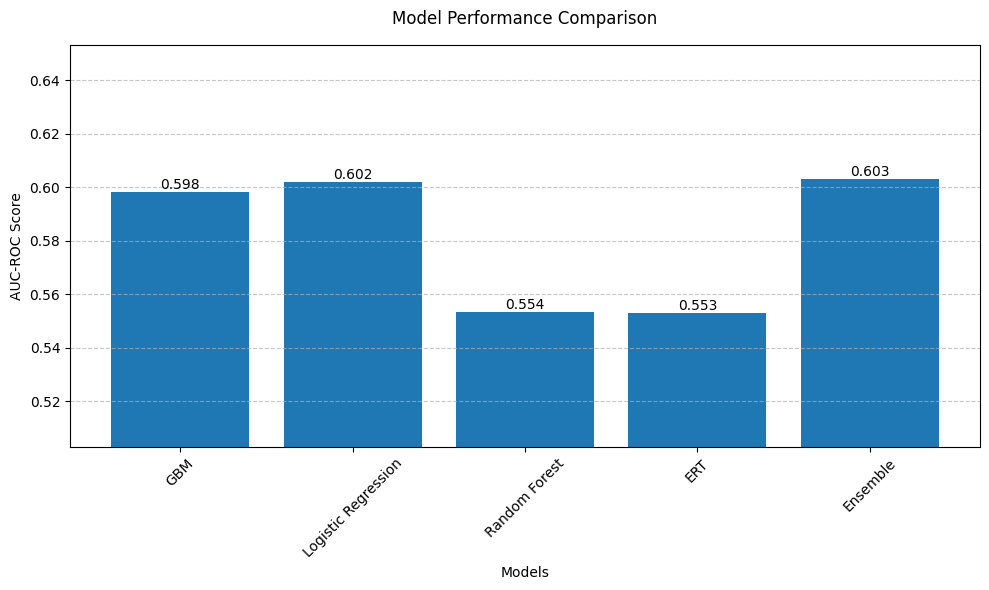

In [30]:
# Calculate AUC scores for each model
model_names = ['GBM', 'Logistic Regression', 'Random Forest', 'ERT', 'Ensemble']
auc_scores = [
    roc_auc_score(val_ens["label"], gbm_val),
    roc_auc_score(val_ens["label"], logReg_val),
    roc_auc_score(val_ens["label"], rf_val),
    roc_auc_score(val_ens["label"], ert_val),
    roc_auc_score(val_ens["label"], logReg_ens_val)
]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, auc_scores)

# Customize the plot
plt.title('Model Performance Comparison', fontsize=12, pad=15)
plt.xlabel('Models')
plt.ylabel('AUC-ROC Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Adjust y-axis to start from a reasonable baseline
plt.ylim(min(auc_scores) - 0.05, max(auc_scores) + 0.05)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

## EXTRAS: Build Intuition for the Bias-Variance Tradeoff

Tasks:
1. Run the code for task 1 to visualize the synthetic data.
  - Think About:
    - Does the data seem to follow a linear or non-linear trend?
    - Can you spot noise in the data?
2. Run the code for task 2 to visualize the fit polynomial models of the following orders: `[1, 2, 3, 10, 20, 30]`. Analyze the fits of each model.
  - Think about:
    - Which models appear to underfit the data (too simple)?
    - Which models appear to overfit the data (too complex)?
    - Where do you see a good balance between bias and variance?
3. Run the code for task 3 and analyze the train and test errors for each model.
  - Think about:
    - At lower degrees, why are both errors high?
    - At higher degrees, why does the test error increase even as training error decreases?
    - Where do you see the best balance between bias and variance?

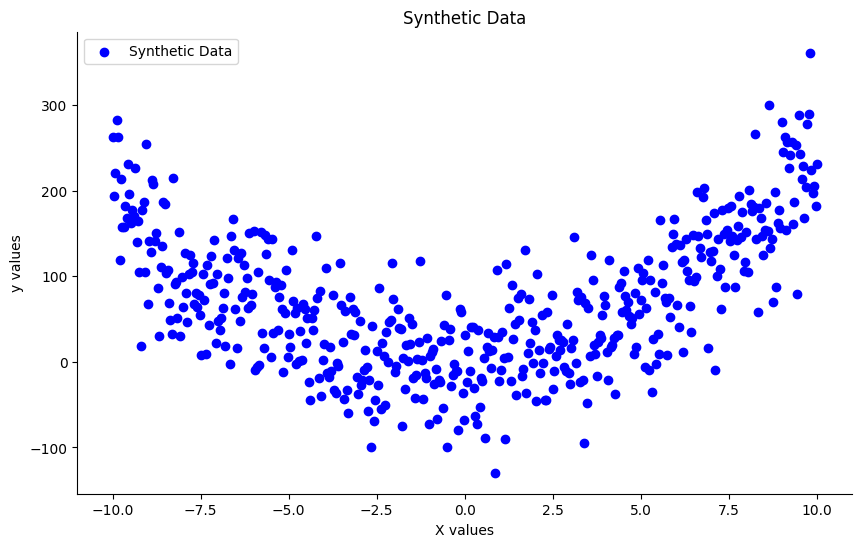

In [31]:
# TASK 1 SOLUTION

# Generate synthetic data
np.random.seed(0)
X = np.linspace(-10, 10, 500).reshape(-1, 1)
y = 2 * X**2 + 3 * X + 5 + np.random.normal(0, 50, X.shape)

# Plot the Synthetic Data
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Synthetic Data')
plt.xlabel('X values')
plt.ylabel('y values')
plt.title('Synthetic Data')
plt.legend()
sns.despine()
plt.show()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

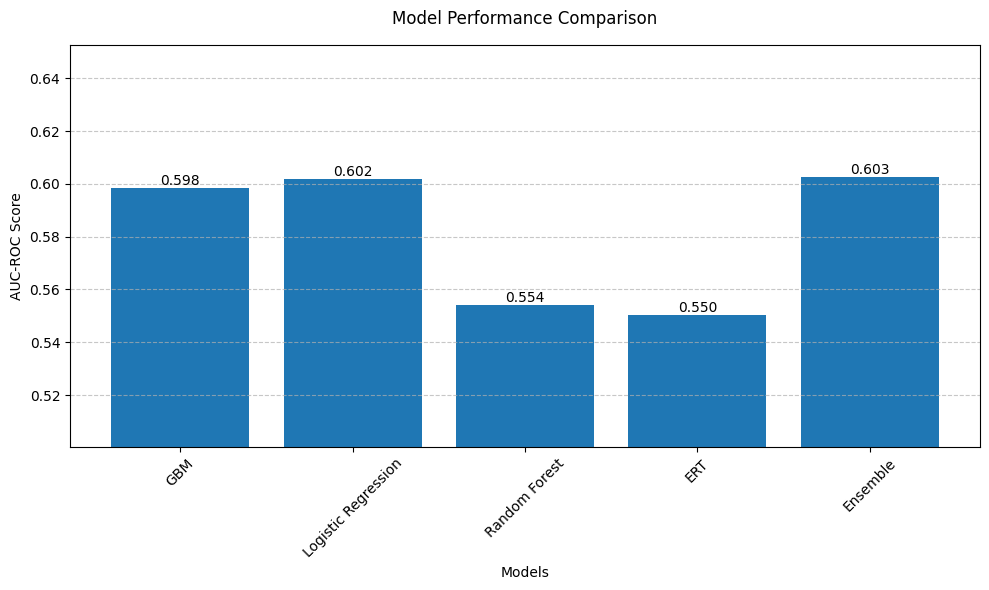

In [ ]:
# Calculate AUC scores for each model
model_names = ['GBM', 'Logistic Regression', 'Random Forest', 'ERT', 'Ensemble']
auc_scores = [
    roc_auc_score(val_ens["label"], gbm_val),
    roc_auc_score(val_ens["label"], logReg_val),
    roc_auc_score(val_ens["label"], rf_val),
    roc_auc_score(val_ens["label"], ert_val),
    roc_auc_score(val_ens["label"], logReg_ens_val)
]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, auc_scores)

# Customize the plot
plt.title('Model Performance Comparison', fontsize=12, pad=15)
plt.xlabel('Models')
plt.ylabel('AUC-ROC Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Adjust y-axis to start from a reasonable baseline
plt.ylim(min(auc_scores) - 0.05, max(auc_scores) + 0.05)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

The meta model with logistic regression only performs slightly better than the baseline logistic regression model!

Challenge: Try out other classifiers to fit the meta model to improve performance further!

You can refer to this **[link](https://scikit-learn.org/dev/auto_examples/classification/plot_classifier_comparison.html)** for some other binary classifier ideas.

In [ ]:
#  Try other models to learn the ensemble meta model
''' ADD YOUR CODE HERE '''

### TASK 1: Visualize the Synthetic Data

In [ ]:
# TASK 1 SOLUTION AND EXERCISE

# Generate synthetic data
np.random.seed(0)
X = np.linspace(-10, 10, 500).reshape(-1, 1)
y = 2 * X**2 + 3 * X + 5 + np.random.normal(0, 50, X.shape)

# Plot the Synthetic Data
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Synthetic Data')
plt.xlabel('X values')
plt.ylabel('y values')
plt.title('Synthetic Data')
plt.legend()
sns.despine()
plt.show()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### TASK 2: Visualize Overfitting and Underfitting

*   Generate polynomial features from the input data and then run polynomial regression
*   Run this for several different degrees of polynomials to understand when overfitting occurs

Use the [PolynomialFeatures](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) function from scikit-learn


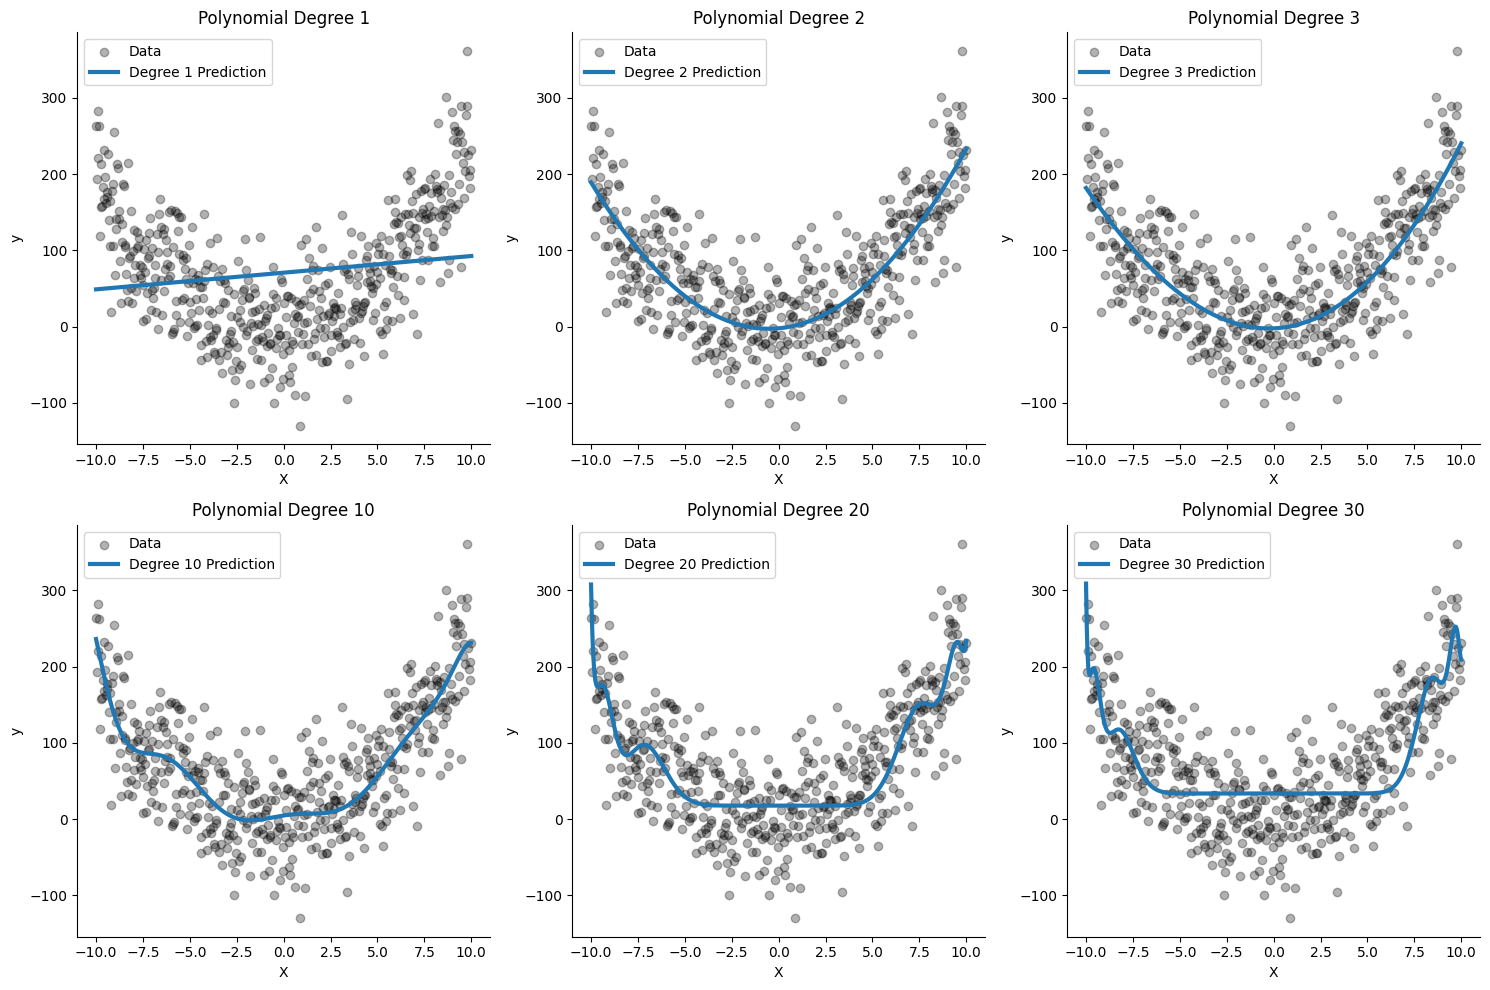

In [32]:
# TASK 2 SOLUTION AND EXERCISE

# Define degrees for Polynomial Regression
degrees = [1, 2, 3, 10, 20, 30]

# To store training and test errors
train_errors = []
test_errors = []

# Step 3: Train models of different polynomial degrees and evaluate
plt.figure(figsize=(15, 10))
for i, degree in enumerate(degrees, 1):

    # Initialize polynomial model for the current degree
    poly = PolynomialFeatures(degree)

    # Create polynomial features from both the train and test inputs
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)

    # Train a linear regression model on polynomial features
    model = LinearRegression()
    model.fit(X_poly_train, y_train)

    # Predict on training and test data
    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    # Calculate and store the mean squared error
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

    # Plot predictions for each model
    X_poly = poly.transform(X)
    y_pred = model.predict(X_poly)

    plt.subplot(2, 3, i)
    plt.scatter(X, y, color='black', label='Data', alpha = .3)
    plt.plot(X, y_pred, label=f'Degree {degree} Prediction', linewidth = 3)
    plt.title(f'Polynomial Degree {degree}')
    plt.xlabel('X')
    plt.ylabel('y')
    sns.despine()
    plt.legend()

plt.tight_layout()
plt.show()

### TASK 3: Where do you see the Bias-Variance tradeoff?

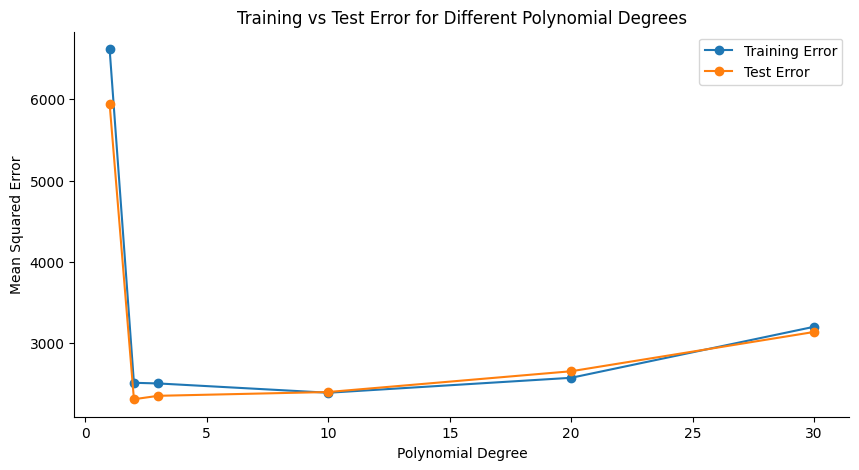

In [33]:
# TASK 3 SOLUTION AND EXERCISE

# Plot Training vs Test Errors
plt.figure(figsize=(10, 5))
plt.plot(degrees, train_errors, marker='o', label='Training Error')
plt.plot(degrees, test_errors, marker='o', label='Test Error')
plt.title('Training vs Test Error for Different Polynomial Degrees')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
sns.despine()
plt.legend()
plt.show()